Output()

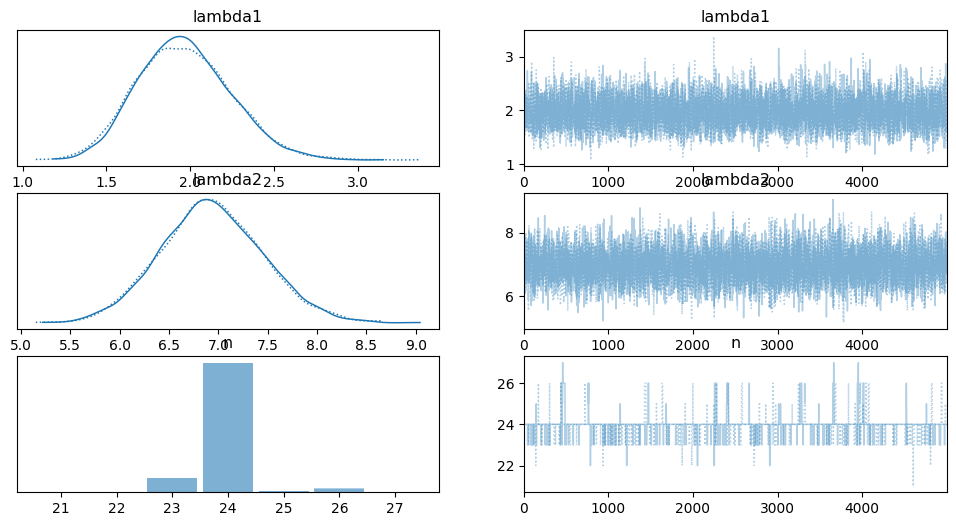

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lambda1   1.966  0.277   1.467    2.492      0.004    0.003    5541.0   
lambda2   6.935  0.518   6.002    7.969      0.006    0.006    6351.0   
n        23.956  0.472  23.000   24.000      0.015    0.029    1113.0   

         ess_tail  r_hat  
lambda1    5354.0    1.0  
lambda2    4686.0    1.0  
n           710.0    1.0  
Posterior mean lambda1: 1.9657359566549546
Posterior mean lambda2: 6.934698044262211
Posterior mean n: 23.9563


In [5]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

random_seed = 42
rng = np.random.default_rng(random_seed)

N = 50 # number of time points, use 50 like in paper
true_n = 25 # change-point
true_lambda1 = 2.0
true_lambda2 = 8.0

# create the true rate for each time point
idx = np.arange(1, N + 1)
true_rate = np.where(idx <= true_n, true_lambda1, true_lambda2)

# observed counts
x = rng.poisson(true_rate)

# changepoint model
cp_model = pm.Model()

# set a and b to values used in the paper
a = 2.0
b = 1.0

num_samples = 5000
warm_up = 2000

with cp_model:
    # prior for the change-point
    # the change point is equally likely to be anywhere between 0 and N−1
    n = pm.DiscreteUniform("n", lower=0, upper=N-1)

    # priors for lamb1 and lamb2
    lambda1 = pm.Gamma("lambda1", alpha=a, beta=b)
    lambda2 = pm.Gamma("lambda2", alpha=a, beta=b)

    # build the rate vector for the likelihood
    t = np.arange(N)

    # rate will be an array of lambda1 and lambda2 like:
    # [L1, L1, L1, ..., L1, L2, L2, ..., L2]
    rate = pm.math.switch(t <= n, lambda1, lambda2)

    # for each data point x[i], model it as Poisson with the recently calculauted rate
    obs = pm.Poisson("obs", mu=rate, observed=x)

    trace = pm.sample(
        num_samples, # real posterior samples
        tune=warm_up, # warm up iterations
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=random_seed
    )

# Summary and plots
az.plot_trace(trace)
plt.show()

print(az.summary(trace, var_names=["lambda1", "lambda2", "n"]))

lambda1_mean = trace.posterior["lambda1"].mean().item()
lambda2_mean = trace.posterior["lambda2"].mean().item()
n_mean = trace.posterior["n"].mean().item()

print("Posterior mean lambda1:", lambda1_mean)
print("Posterior mean lambda2:", lambda2_mean)
print("Posterior mean n:", n_mean)